### Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Getting the Data from Yfinance

In [2]:
# Getting the current date
from datetime import date
today = date.today()
today

datetime.date(2020, 7, 26)

In [3]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = today,
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


### Creating the Data

In [4]:
df_comp = raw_data.copy()

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

### Creating Returns

In [7]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [8]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

### Splitting the data

In [9]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting the model

In [10]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

### Simple Forecasting

In [11]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2015-03-27,2061.020020,11868.330078,6855.000000,19285.630859,0.236856,-0.584453,0.208131,-0.952633,20.726033,372.974512,9252.593566,-54.051105
2015-03-30,2086.239990,12086.009766,6891.399902,19411.400391,1.223665,0.530998,1.834122,0.652141,107.076438,-338.861420,81536.980067,37.001608
2015-03-31,2067.889893,11966.169922,6773.000000,19206.990234,-0.879578,-1.718082,-0.991558,-1.053042,-76.967196,1096.410685,-44080.308616,-59.748171
2015-04-01,2059.689941,12001.379883,6809.500000,19034.839844,-0.396537,0.538904,0.294246,-0.896290,-34.698876,-343.907111,13080.872446,-50.854303
2015-04-02,2066.959961,11967.389648,6833.500000,19312.789062,0.352967,0.352449,-0.283219,1.460213,30.886257,-224.918607,-12590.683576,82.850521


In [12]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2015-04-03"
end_date = today

In [13]:
df_pred = results_ar.predict(start = start_date, end = end_date)

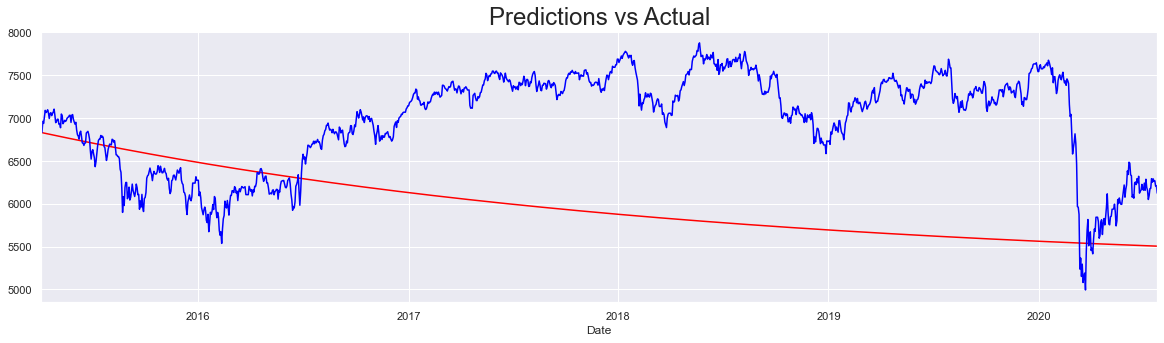

In [14]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

from the model above we can say that AR models are not the best estimators for non-stationary data. The red curve decreases while the blue curve is way ahead of its magnitude.

### Using Returns Instead

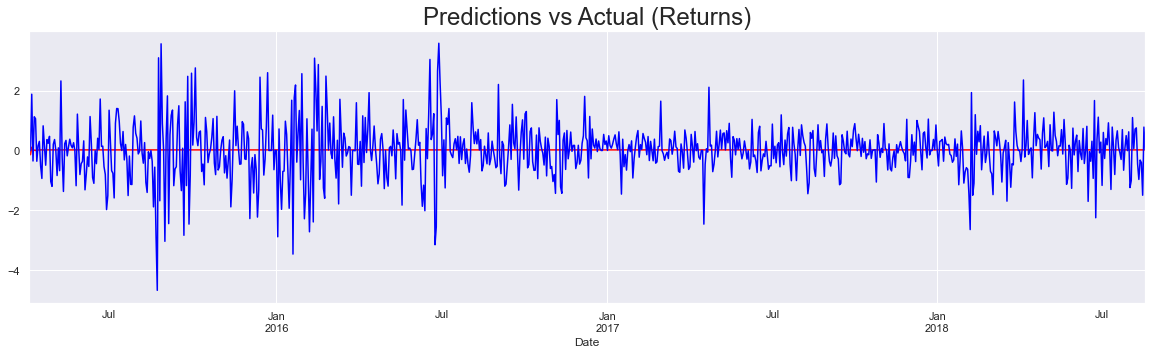

In [15]:
end_date = "2018-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [16]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5539
Model:                     ARMA(5, 0)   Log Likelihood               -8557.542
Method:                       css-mle   S.D. of innovations              1.134
Date:                Sun, 26 Jul 2020   AIC                          17129.083
Time:                        20:54:31   BIC                          17175.420
Sample:                    01-10-1994   HQIC                         17145.240
                         - 04-02-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0189      0.013      1.447      0.148      -0.007       0.045
ar.L1.ret_ftse    -0.0214      0.013     -1.594      0.111      -0.048       0.005
ar.L2.ret_ftse    -0.0523      0.013     -3.899      0.000      -0.079      -0.026
ar.L3.ret_ftse    -0.0762      0.013     -5.695      0.000      -0.102      -0.050
ar.L4.ret_ftse     0.0406      0.013      3.029      0.002       0.014       0.067
ar.L5.ret_ftse    -0.0566      0.013     -4.220      0.000      -0.083      -0.030
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5748           -0.0000j            1.5748           -0.5000
AR.2           -0.3032           -1.7416j            1.7678           -0.2774
AR.3           -0.3032           +1.7416j            1.7678            0.2774
AR.4            1.4493           -1.2200j            1.8945           -0.1114
AR.5            1.4493           +1.2200j            1.8945            0.1114
-----------------------------------------------------------------------------
"""

### MA

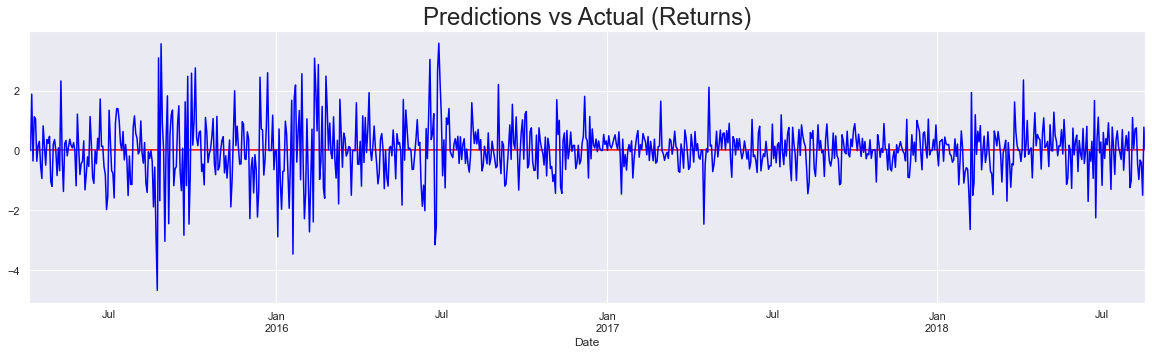

In [18]:
start_date = "2015-04-03"
end_date = "2018-08-18"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [19]:
df_pred_ma.head()

2015-04-03    0.010347
2015-04-06    0.018884
2015-04-07    0.018884
2015-04-08    0.018884
2015-04-09    0.018884
Freq: B, dtype: float64

We can clearly see that the prediction powers of AR and MA models is really low. Lets go for the other models.


### ARMA

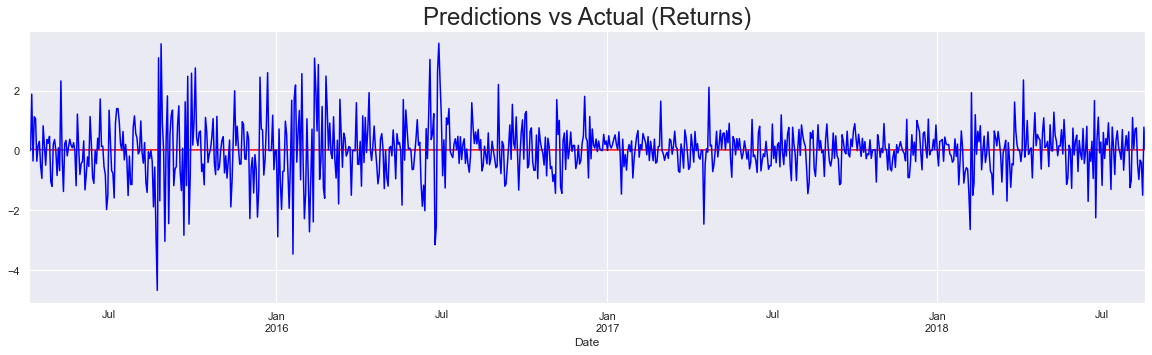

In [20]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [21]:
df_pred_arma.head()

2015-04-03    0.051654
2015-04-06    0.044584
2015-04-07    0.039042
2015-04-08    0.034698
2015-04-09    0.031293
Freq: B, dtype: float64

In [22]:
df_pred_arma.tail()

2018-08-14    0.018943
2018-08-15    0.018943
2018-08-16    0.018943
2018-08-17    0.018943
2018-08-20    0.018943
Freq: B, dtype: float64

ARMA is better predictor as the values change in the head method while it flats our completely later. This model is not a good predictor.


### ARMAX

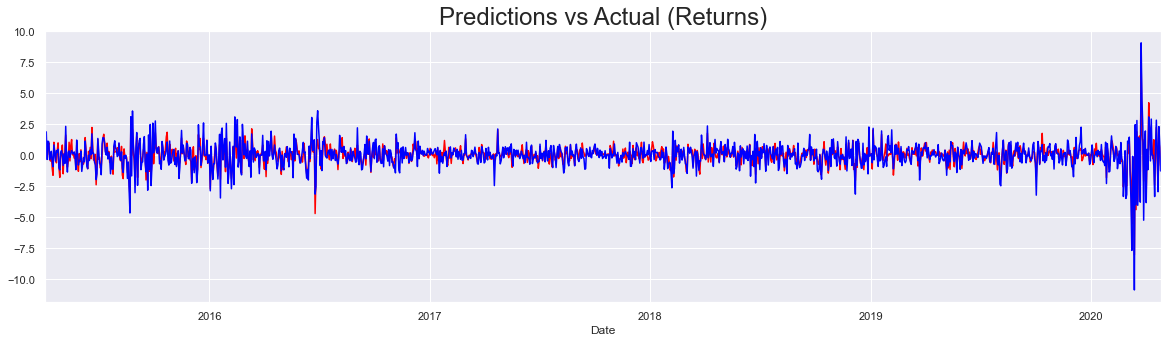

In [31]:
start_date = "2015-04-03"
end_date = "2020-04-24"
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

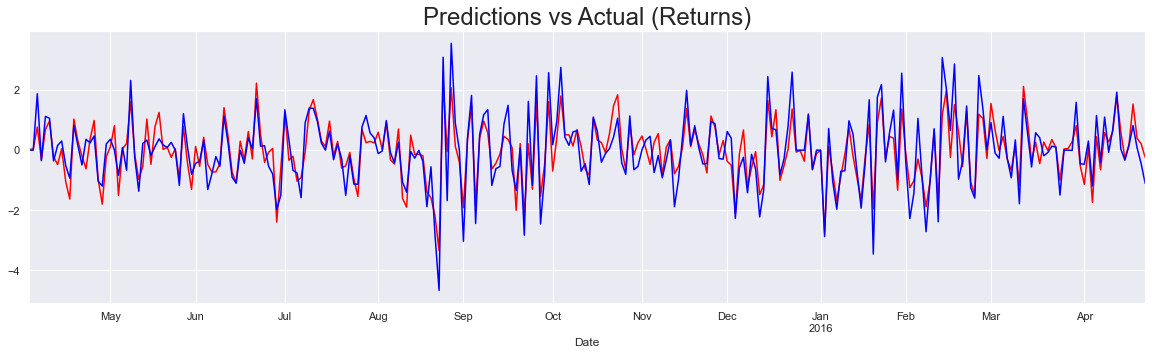

In [34]:
# Lets zoom in a bit

start_date = "2015-04-03"
end_date = "2016-04-22"
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

We can clearly see that the predictions have drastically been improved. Sometimes it superceedes the real figures and sometimes deceedes the real figures but still it is following a good pattern. Including outside factors improved the predictive power drastically. Regular ARMA models can't incorporate any outside real world effects. We are allowing the model to take the data from today and the information from past periods. 

There is a difference between forecasts and predictions. Predictions are the in-sample estimations while forecasts are out of sample estimations.

MAX models can be great in order to analyse the data but poor in terms of forecast the data. We only use integrated models on non-stationary data because predictions will be integrated prices.

### SARMA

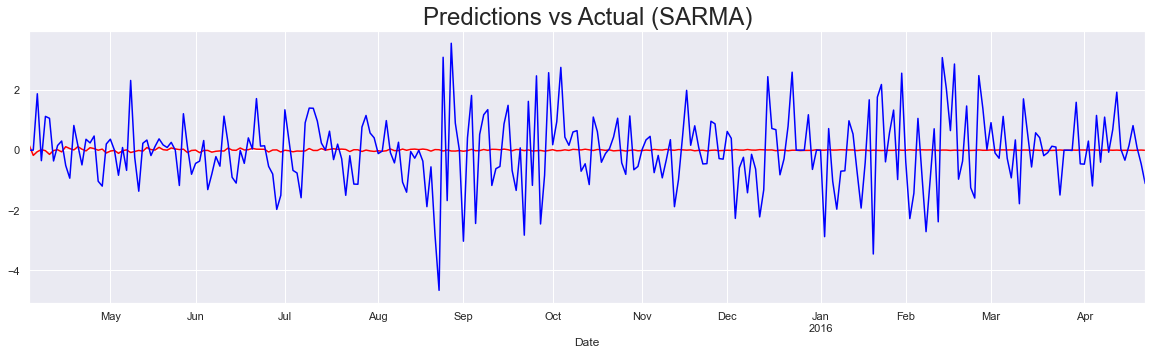

In [35]:
start_date = "2015-04-03"
end_date = "2016-04-22"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

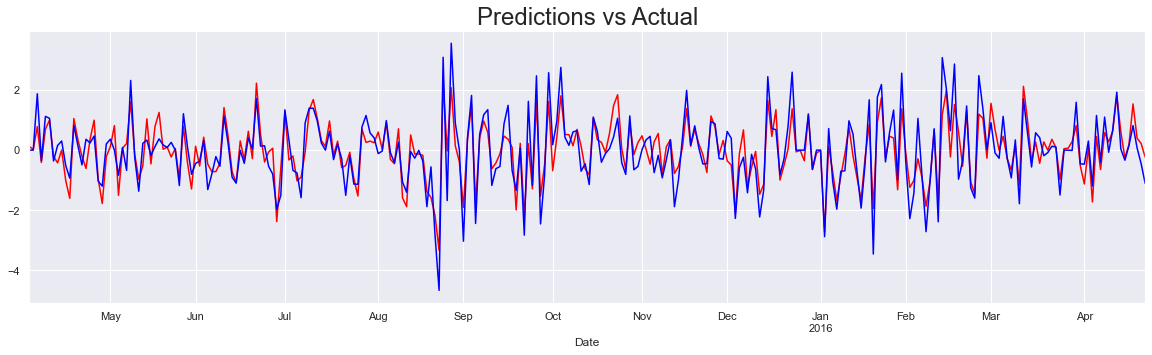

In [36]:
start_date = "2015-04-03"
end_date = "2016-04-22"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

We can clearly see that the predictions have been drastically improved.


### Auto ARIMA

In [37]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [38]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

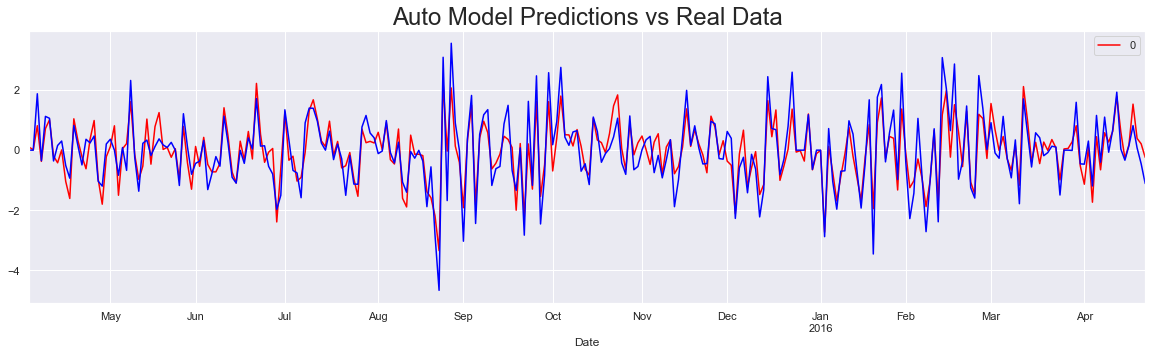

In [39]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

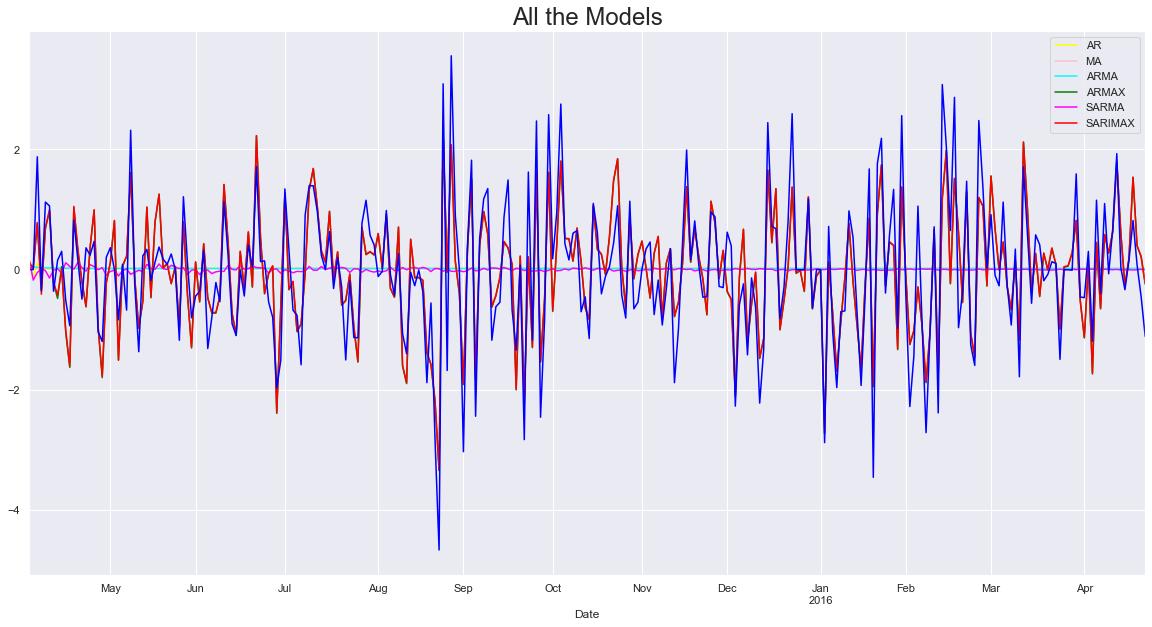

In [44]:
start_date = "2015-04-03"
end_date = "2016-04-22"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volitility

In [45]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7536.171796612216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7536.171796612216
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


In [48]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

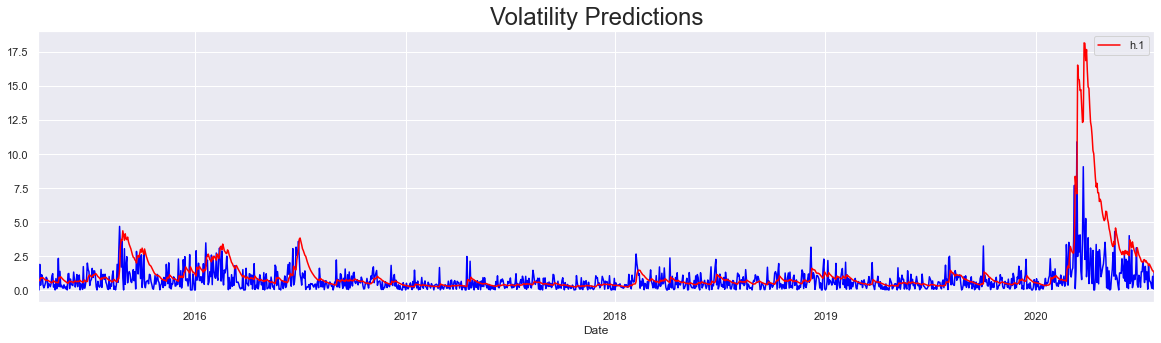

In [49]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [50]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-24,1.258804,1.375356,1.402146,1.529381,1.645524,1.762943,1.87673,1.764775,1.921553,1.949633,...,6.97562,7.481998,7.40094,7.705692,7.670527,8.077038,3.853415,4.058403,4.366898,2.305064


### Multvariate Regression Model

In [51]:
from statsmodels.tsa.api import VAR

In [52]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [53]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [54]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Jul, 2020
Time:                     01:38:07
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.275667
Nobs:                     5534.00    HQIC:                  0.210234
Log likelihood:          -31810.4    FPE:                    1.19149
AIC:                     0.175203    Det(Omega_mle):         1.17357
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.038613         0.015739            2.453           0.014
L1.ret_spx           -0.110165         0.017234           -6.392           0.000
L1.ret_dax            0.062291         0.018575           

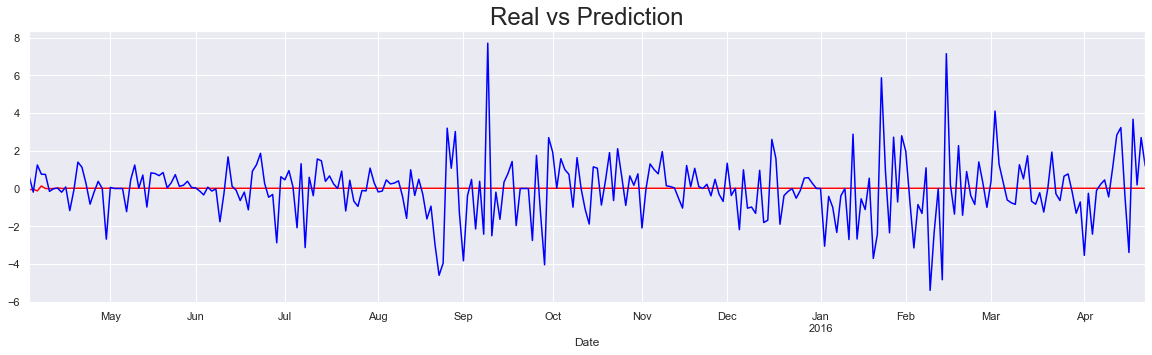

In [55]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

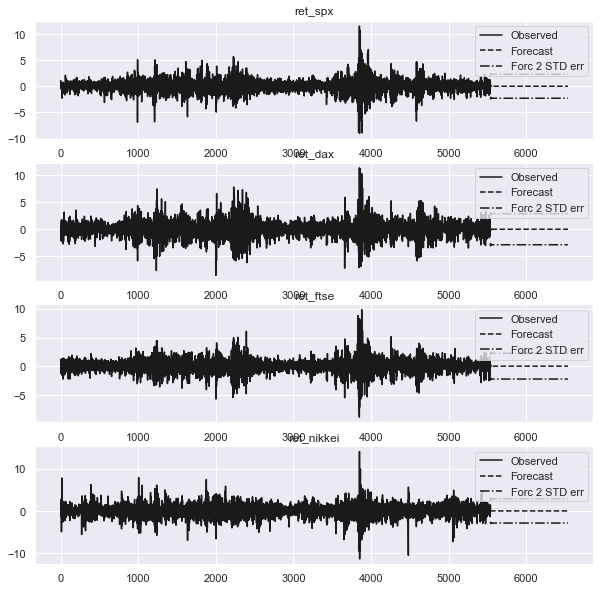

In [56]:
results_var_ret.plot_forecast(1000)
plt.show()